## Predicting the Helpfulness of Amazon Fine Food Reviews

### Purpose

Build a model to predict the helpfulness of Amazon Fine Food Reviews. This will improve Amazon's selection of helpful reviews at the top of the review section and improve customer's purchasing decisions. It could also help other reviewers as a guide to writing helpful reviews.

This dataset comes from over 568,0454 Amazon Fine Food Reviews. 

Variable | Description | Type of Variable
---| ---| ---
HelpfulnessNumerator | number of users who found the review helpful | continuous
HelpfulnessDenominator | number of users who indicated whether they found the review helpful or not helpful | continuous
Score | rating between 1 and 5 | categorical
Text | text of the review | text

## Load the Data

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read data into a DataFrame
data = pd.read_csv('Reviews.csv', index_col=0)

#make a copy of columns I need from raw data
df1 = data.iloc[:, [3,4,5,8]]
df1.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
Id,,,,
1,1,1,5,I have bought several of the Vitality canned d...
2,0,0,1,Product arrived labeled as Jumbo Salted Peanut...
3,1,1,4,This is a confection that has been around a fe...
4,3,3,2,If you are looking for the secret ingredient i...
5,0,0,5,Great taffy at a great price. There was a wid...


In [5]:
df1["Id"][44737]

KeyError: 'Id'

In [4]:
#change data type of non-Text features from string to integer
df1.loc[:, 0:3] = df1.iloc[:, 0:3].apply(pd.to_numeric)

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
#include reviews that have more than 10 helpfulness data point only
df1 = df1[(df1.HelpfulnessDenominator > 10)]

In [6]:
print df1['Score'].shape

(21463,)


#### Notes
I have only included reviews that have more than 10 votes from users on whether the review was helpful or not. With this filter, the dataset is significantly reduce from 560,000+ reviews to 21,463 reviews.

## Clean the Data

In [7]:
#check for missing values
print df1.isnull().sum()

HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Text                      0
dtype: int64


In [8]:
# convert text to lowercase
df1.loc[:, 'Text'] = df1['Text'].str.lower()
df1["Text"].head(10)

Id
33     mccann's instant oatmeal is great if you must ...
34     this is a good instant oatmeal from the best o...
83     i know the product title says molecular gastro...
159    <span class="tiny"> length:: 0:26 mins<br /><b...
288    this is a fantastic product, and i wish it was...
325    so we cancelled the order.  it was cancelled w...
382    these condiments are overpriced and terrible. ...
523    i first discovered kettle chips with sea salt ...
524    you don't need salt to hide the taste of potat...
525    these potato chips are excellent.there are no ...
Name: Text, dtype: object

In [10]:
#remove html tags
import bleach
df1["Text"] = df1['Text'].apply(lambda x: bleach.clean(x, tags=[], strip=True))
df1["Text"].head(4)

Id
33     mccann's instant oatmeal is great if you must ...
34     this is a good instant oatmeal from the best o...
83     i know the product title says molecular gastro...
159     length:: 0:26 minsthe expiration date is 21 m...
Name: Text, dtype: object

In [17]:
#remove punctuation
import unicodedata
import sys

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P'))
def remove_punctuation(text):
    return text.translate(tbl)

df1['Text']=df1['Text'].apply( lambda x: remove_punctuation(x))
df1["Text"].head(4)

In [25]:
df1['Score'].shape

(21463,)

#### Notes
I chose not to use the Porter Stemmer method after reviewing other kernels on Kaggle where the method generated less accurate predictions.

## Exploratory Data Analysis

### Create a binary variable "Helpfulness"

In [44]:
#transform Helpfulness into a binary variable with 0.50 ratio
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'HelpfulnessNumerator'] / df1.loc[:, 'HelpfulnessDenominator'] > 0.50, 1, 0)
df1.head(3)

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,Helpful
Id,,,,,
33,19,19,4,mccanns instant oatmeal is great if you must h...,1
34,13,13,4,this is a good instant oatmeal from the best o...,1
83,15,15,5,i know the product title says molecular gastro...,1


In [45]:
df1.groupby('Helpful').count()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
Helpful,,,,
0,4100,4100,4100,4100
1,17363,17363,17363,17363


In [46]:
df1.corr()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Helpful
HelpfulnessNumerator,1.000000,0.975746,0.145338,0.228370
HelpfulnessDenominator,0.975746,1.000000,0.048775,0.080156
Score,0.145338,0.048775,1.000000,0.457537
Helpful,0.228370,0.080156,0.457537,1.000000


### Bag of Words Model

In [47]:
#make a copy
df2 = df1.copy(deep = True)

In [48]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9,
                             ngram_range=(1, 4), 
                             stop_words='english')
vectorizer.fit(df2['Text'])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.1,
        ngram_range=(1, 4), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [49]:
X_train = vectorizer.transform(df2['Text'])
vocab = vectorizer.get_feature_names()

In [54]:
#find best logistic regression parameters
from sklearn import grid_search, cross_validation
from sklearn.linear_model import LogisticRegression
feature_set = X_train
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(df1.Helpful,n_folds=10),
    scoring='roc_auc'
)


gs.fit(X_train, df2.Helpful)
gs.grid_scores_

[mean: 0.71697, std: 0.01405, params: {'C': 100000, 'class_weight': None},
 mean: 0.71758, std: 0.01404, params: {'C': 100000, 'class_weight': 'balanced'},
 mean: 0.71697, std: 0.01405, params: {'C': 10000, 'class_weight': None},
 mean: 0.71758, std: 0.01404, params: {'C': 10000, 'class_weight': 'balanced'},
 mean: 0.71697, std: 0.01404, params: {'C': 1000, 'class_weight': None},
 mean: 0.71757, std: 0.01404, params: {'C': 1000, 'class_weight': 'balanced'},
 mean: 0.71697, std: 0.01405, params: {'C': 100, 'class_weight': None},
 mean: 0.71758, std: 0.01404, params: {'C': 100, 'class_weight': 'balanced'},
 mean: 0.71697, std: 0.01404, params: {'C': 10, 'class_weight': None},
 mean: 0.71755, std: 0.01405, params: {'C': 10, 'class_weight': 'balanced'},
 mean: 0.71697, std: 0.01405, params: {'C': 1, 'class_weight': None},
 mean: 0.71749, std: 0.01407, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.71683, std: 0.01455, params: {'C': 0.1, 'class_weight': None},
 mean: 0.71708, std: 0

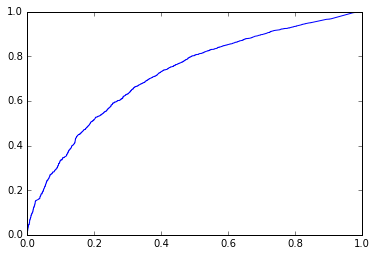

In [60]:
#plot ROC/AUC curve
from sklearn.metrics import roc_auc_score, roc_curve
actuals = gs.predict(feature_set) 
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df2[['Helpful']], probas[:,1])[0], roc_curve(df2[['Helpful']], probas[:,1])[1])

In [61]:
# ROC/AUC score
y_score = probas
test2 = np.array(list(df2.Helpful))
test2 = test2.reshape(21463,1)
y_true = test2
roc_auc_score(y_true, y_score[:,1].T)

0.72117095786807661

#### Notes
The Bag of Words model performs poorly with only 72% accuracy.

## K-Means Clustering of Reviews to select Top 10 words per Cluster

Hypothesis: There's a natural clustering to review vocabulary. I can use the most descriptive clusters to simplify the model.

In [62]:
#Apply TfidfVectorizer to review text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [63]:
model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)

In [64]:
vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 2), 
                             stop_words='english')
vectorizer.fit(df1['Text'])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.95, max_features=None, min_df=0.05,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [65]:
X_train = vectorizer.transform(df1['Text'])
vocab = vectorizer.get_feature_names()
sse_err = []
res = model.fit(X_train)
vocab = np.array(vocab)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()
for i in xrange(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)

In [66]:
words

[u'product',
 u'good',
 u'eating',
 u'dont',
 u'just',
 u'taste',
 u'tea',
 u'price',
 u'use',
 u'coffee',
 u'diet',
 u'foods',
 u'buy',
 u'ordered',
 u'flavor',
 u'eat',
 u'really',
 u'box',
 u'received',
 u'great',
 u'natural',
 u'like',
 u'ingredients',
 u'dog',
 u'shipping',
 u'sugar',
 u'food',
 u'amazon',
 u'sweet',
 u'order']

In [67]:
#select top 10 words per cluster
train_set=X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

In [68]:
print len(vectorizer.vocabulary_)
print len(words)
print words

146
30


In [71]:
df1['cluster'] = model.labels_
df1.groupby('cluster').count()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,Helpful
cluster,,,,,
0,12429,12429,12429,12429,12429
1,1136,1136,1136,1136,1136
2,2279,2279,2279,2279,2279
3,5619,5619,5619,5619,5619


In [72]:
df1.groupby('cluster').mean()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Helpful
cluster,,,,
0,21.769088,26.169040,3.726688,0.832167
1,19.266725,23.336268,3.412852,0.859155
2,18.263712,23.078104,3.146556,0.811760
3,16.743371,22.727532,2.798541,0.746396


In [97]:
df1.corr()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Helpful,cluster
HelpfulnessNumerator,1.000000,0.975746,0.145338,0.228370,-0.065908
HelpfulnessDenominator,0.975746,1.000000,0.048775,0.080156,-0.045438
Score,0.145338,0.048775,1.000000,0.457537,-0.231141
Helpful,0.228370,0.080156,0.457537,1.000000,-0.088776
cluster,-0.065908,-0.045438,-0.231141,-0.088776,1.000000


#### Notes
There doesn't seem to be a clear trend to the clusters. I cannot make a silhoute coefficient plot due to computer storage capacity, so I chose 4 clusters. With more clusters, the number of overlapping "top words" from each cluster seems to increase. In total there are only 30 "top words" instead of 40, because some top words overlapped among clusters. There may be some common words that I should consider removing in further analysis, like "food"" or "coffee".

## Logistic Regression to Predict Review Helpfulness

In [74]:
print train_set.shape

(21463, 30)


In [75]:
#add Score column to top words
import scipy as scipy

score = np.array(list(df1.Score))
score = score.reshape(21463, 1)

features = scipy.sparse.hstack((train_set,scipy.sparse.csr_matrix(score)))

features = scipy.sparse.csr_matrix(features)

In [80]:
features.shape

(21463, 31)

In [81]:
#find best logistic regression parameters
from sklearn import grid_search, cross_validation
from sklearn.linear_model import LogisticRegression
feature_set = features
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(df1.Helpful,n_folds=10),
    scoring='roc_auc'
)


gs.fit(features, df1.Helpful)
gs.grid_scores_

[mean: 0.82438, std: 0.01544, params: {'C': 100000, 'class_weight': None},
 mean: 0.82442, std: 0.01520, params: {'C': 100000, 'class_weight': 'balanced'},
 mean: 0.82438, std: 0.01544, params: {'C': 10000, 'class_weight': None},
 mean: 0.82442, std: 0.01520, params: {'C': 10000, 'class_weight': 'balanced'},
 mean: 0.82438, std: 0.01544, params: {'C': 1000, 'class_weight': None},
 mean: 0.82442, std: 0.01521, params: {'C': 1000, 'class_weight': 'balanced'},
 mean: 0.82438, std: 0.01544, params: {'C': 100, 'class_weight': None},
 mean: 0.82442, std: 0.01521, params: {'C': 100, 'class_weight': 'balanced'},
 mean: 0.82436, std: 0.01543, params: {'C': 10, 'class_weight': None},
 mean: 0.82441, std: 0.01522, params: {'C': 10, 'class_weight': 'balanced'},
 mean: 0.82420, std: 0.01546, params: {'C': 1, 'class_weight': None},
 mean: 0.82437, std: 0.01522, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.82328, std: 0.01568, params: {'C': 0.1, 'class_weight': None},
 mean: 0.82377, std: 0

In [82]:
print gs.best_estimator_

LogisticRegression(C=100000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [83]:
y_pred = gs.predict(feature_set)

In [84]:
# Coefficients represent the log-odds
print gs.best_estimator_.coef_
print gs.best_estimator_.intercept_

[[-0.01635048 -0.05112683 -0.13767222 -0.07921834  0.15387005  0.54744671
   0.41523978  1.30989353  0.84731167  1.21244747  0.82515766  0.62386485
   0.0259244   0.60505512  1.50019033 -0.05077692  0.96736664  0.50413388
   0.27758878  1.29099849  0.72795271 -0.13692833  0.87533361  0.47230123
   0.63551493  1.22613997  1.24989992  0.81675697  0.03172085 -0.0581862
   0.78162312]]
[-2.62611095]


In [85]:
print gs.best_estimator_.score(feature_set, df1.Helpful)

0.748637189582


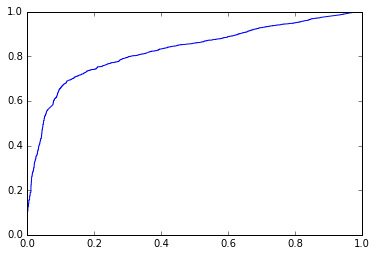

In [86]:
#roc curve
from sklearn.metrics import roc_auc_score, roc_curve
actuals = gs.predict(feature_set) 
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df1[['Helpful']], probas[:,1])[0], roc_curve(df1[['Helpful']], probas[:,1])[1])

In [87]:
#roc auc score
y_score = probas
test2 = np.array(list(df1.Helpful))
test2 = test2.reshape(21463,1)
y_true = test2

roc_auc_score(y_true, y_score[:,1].T)

0.82689467932230443

Confusion matrix, without normalization
[[ 3373   727]
 [ 4668 12695]]
Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.27  0.73]]


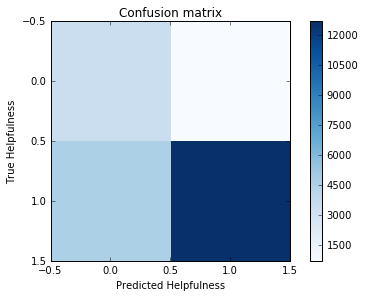

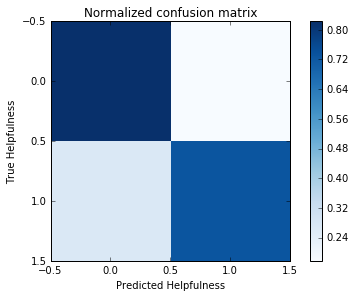

In [88]:
#plot a confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True Helpfulness')
    plt.xlabel('Predicted Helpfulness')


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [89]:
print len(vectorizer.vocabulary_)
print len(gs.best_estimator_.coef_[0])

146

In [91]:
words

[u'product',
 u'good',
 u'eating',
 u'dont',
 u'just',
 u'taste',
 u'tea',
 u'price',
 u'use',
 u'coffee',
 u'diet',
 u'foods',
 u'buy',
 u'ordered',
 u'flavor',
 u'eat',
 u'really',
 u'box',
 u'received',
 u'great',
 u'natural',
 u'like',
 u'ingredients',
 u'dog',
 u'shipping',
 u'sugar',
 u'food',
 u'amazon',
 u'sweet',
 u'order']

In [92]:
len(words)

30

In [93]:
gs.best_estimator_.coef_[0]

array([-0.02, -0.05, -0.14, -0.08,  0.15,  0.55,  0.42,  1.31,  0.85,
        1.21,  0.83,  0.62,  0.03,  0.61,  1.5 , -0.05,  0.97,  0.5 ,
        0.28,  1.29,  0.73, -0.14,  0.88,  0.47,  0.64,  1.23,  1.25,
        0.82,  0.03, -0.06,  0.78])

In [94]:
words.extend(['score'])

In [95]:
zip(words,gs.best_estimator_.coef_[0])

[(u'product', -0.016350480682740177),
 (u'good', -0.051126831442664611),
 (u'eating', -0.13767222465681389),
 (u'dont', -0.079218340825083347),
 (u'just', 0.15387005323041639),
 (u'taste', 0.54744670958555586),
 (u'tea', 0.41523978144897639),
 (u'price', 1.3098935293396139),
 (u'use', 0.84731167363098814),
 (u'coffee', 1.2124474746181022),
 (u'diet', 0.8251576575015227),
 (u'foods', 0.62386484672135356),
 (u'buy', 0.025924402603314925),
 (u'ordered', 0.60505512086464919),
 (u'flavor', 1.5001903336871718),
 (u'eat', -0.050776921506864345),
 (u'really', 0.9673666373694898),
 (u'box', 0.5041338837510384),
 (u'received', 0.2775887812436299),
 (u'great', 1.2909984942246358),
 (u'natural', 0.72795270615576102),
 (u'like', -0.13692833406250035),
 (u'ingredients', 0.87533360698575802),
 (u'dog', 0.472301228695235),
 (u'shipping', 0.63551492863383474),
 (u'sugar', 1.2261399698600999),
 (u'food', 1.2498999225667011),
 (u'amazon', 0.8167569654032012),
 (u'sweet', 0.031720852501105921),
 (u'order'

In [96]:
sorted(zip(words,gs.best_estimator_.coef_[0]),key=lambda x:x[1])

[(u'eating', -0.13767222465681389),
 (u'like', -0.13692833406250035),
 (u'dont', -0.079218340825083347),
 (u'order', -0.058186197510553393),
 (u'good', -0.051126831442664611),
 (u'eat', -0.050776921506864345),
 (u'product', -0.016350480682740177),
 (u'buy', 0.025924402603314925),
 (u'sweet', 0.031720852501105921),
 (u'just', 0.15387005323041639),
 (u'received', 0.2775887812436299),
 (u'tea', 0.41523978144897639),
 (u'dog', 0.472301228695235),
 (u'box', 0.5041338837510384),
 (u'taste', 0.54744670958555586),
 (u'ordered', 0.60505512086464919),
 (u'foods', 0.62386484672135356),
 (u'shipping', 0.63551492863383474),
 (u'natural', 0.72795270615576102),
 ('score', 0.78162311955143449),
 (u'amazon', 0.8167569654032012),
 (u'diet', 0.8251576575015227),
 (u'use', 0.84731167363098814),
 (u'ingredients', 0.87533360698575802),
 (u'really', 0.9673666373694898),
 (u'coffee', 1.2124474746181022),
 (u'sugar', 1.2261399698600999),
 (u'food', 1.2498999225667011),
 (u'great', 1.2909984942246358),
 (u'pric

#### Notes
There seem to be common words that I should remove from the text in further analysis, like food, product, or Amazon.

My model is 82% accurate, which is 10% increase in accuracy over the Bag of Words model.

## Recommendations
Price, Flavor, and Great are the top indicators of a helpful review. This indicates a possible bias among customers to mark a review as helpful when the review is positive. Eating, Like, Don't, Order, Good, and Eat are all negatively correlated with a helpful review, which is difficult to interpret. These may be more common words to remove.

Moving forward, I would explore the following methods to improve this analysis:

1) I would explore alternative definitions of an "unhelpful" review. For example, reviews that are not market as "helpful" could be classified as unhelpful. This may help counter consumer-bias if consumers are less likely to mark a negative review as helpful, because it did not enable them to buy the product. This problem requires more domain expertise on consumer behavior.

2) I would explore curating a domain-specific dictionary for this project to avoid common food words and Amazon words in reviews.

3) I would explore using these findings as a guide for reviewers. For example, when writing a review, Amazon could show "Tips for writing a helpful review": "Describe the flavor of this product" ("Flavor" is the most highly correlated parameter with "helpfulness"), "Describe the value of this product compared to its price", etc.

## Acknowedgements
I would like to thank Sri Kanajan Dan Grigoras for their invaluable guidance on this project and throughout the course.